In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"

spambase_df = pd.read_csv(url, header=None)

print(spambase_df.head())


     0     1     2    3     4     5     6     7     8     9   ...    48  \
0  0.00  0.64  0.64  0.0  0.32  0.00  0.00  0.00  0.00  0.00  ...  0.00   
1  0.21  0.28  0.50  0.0  0.14  0.28  0.21  0.07  0.00  0.94  ...  0.00   
2  0.06  0.00  0.71  0.0  1.23  0.19  0.19  0.12  0.64  0.25  ...  0.01   
3  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   
4  0.00  0.00  0.00  0.0  0.63  0.00  0.31  0.63  0.31  0.63  ...  0.00   

      49   50     51     52     53     54   55    56  57  
0  0.000  0.0  0.778  0.000  0.000  3.756   61   278   1  
1  0.132  0.0  0.372  0.180  0.048  5.114  101  1028   1  
2  0.143  0.0  0.276  0.184  0.010  9.821  485  2259   1  
3  0.137  0.0  0.137  0.000  0.000  3.537   40   191   1  
4  0.135  0.0  0.135  0.000  0.000  3.537   40   191   1  

[5 rows x 58 columns]


In [26]:
not_spam = spambase_df[spambase_df.iloc[:, -1] == 0]
spam = spambase_df[spambase_df.iloc[:, -1] == 1]

In [27]:
prior_not_spam = len(not_spam) / len(spambase_df)
prior_spam = len(spam) / len(spambase_df)

In [28]:
summary_not_spam = not_spam.describe()
summary_spam = spam.describe()

In [29]:
import numpy as np

def gaussian_pdf(x, mean, stdev):
    epsilon = 1e-9
    if stdev < epsilon:
        stdev = epsilon
    exponent = np.exp(-((x - mean) ** 2) / (2 * stdev ** 2))
    return (1 / (np.sqrt(2 * np.pi) * stdev)) * exponent

In [30]:
def predict_and_show_posteriors(row):
    log_posterior_not_spam = np.log(prior_not_spam)
    for i in range(len(row) - 1):
        mean = summary_not_spam.iloc[1, i]
        stdev = summary_not_spam.iloc[2, i]
        log_posterior_not_spam += np.log(gaussian_pdf(row[i], mean, stdev))

    log_posterior_spam = np.log(prior_spam)
    for i in range(len(row) - 1):
        mean = summary_spam.iloc[1, i]
        stdev = summary_spam.iloc[2, i]
        log_posterior_spam += np.log(gaussian_pdf(row[i], mean, stdev))
        
    max_log = max(log_posterior_not_spam, log_posterior_spam)
    
    post_not_spam_unnormalized = np.exp(log_posterior_not_spam - max_log)
    post_spam_unnormalized = np.exp(log_posterior_spam - max_log)
    
    evidence = post_not_spam_unnormalized + post_spam_unnormalized
    
    posterior_not_spam = post_not_spam_unnormalized / evidence
    posterior_spam = post_spam_unnormalized / evidence

    decision = 0 if posterior_not_spam > posterior_spam else 1
    
    return decision, posterior_not_spam, posterior_spam

In [21]:
X = spambase_df.iloc[:, :-1]
y = spambase_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- Posterior Probabilities for Test Samples ---")
# Let's check the first 5 emails from the test set
for i in range(5):
    row = X_test.iloc[i]
    true_label = y_test.iloc[i]
    decision, post_not_spam, post_spam = predict_and_show_posteriors(row)
    
    print(f"\nSample #{i+1}:")
    print(f"  Posterior P(Not Spam | features): {post_not_spam:.4f}")
    print(f"  Posterior P(Spam | features)    : {post_spam:.4f}")
    print(f"  Model Decision: {'Not Spam' if decision == 0 else 'Spam'}")
    print(f"  Actual Label  : {'Not Spam' if true_label == 0 else 'Spam'}")

--- Posterior Probabilities for Test Samples ---

Sample #1:
  Posterior P(Not Spam | features): 0.0000
  Posterior P(Spam | features)    : 1.0000
  Model Decision: Spam
  Actual Label  : Not Spam

Sample #2:
  Posterior P(Not Spam | features): 1.0000
  Posterior P(Spam | features)    : 0.0000
  Model Decision: Not Spam
  Actual Label  : Not Spam

Sample #3:
  Posterior P(Not Spam | features): 1.0000
  Posterior P(Spam | features)    : 0.0000
  Model Decision: Not Spam
  Actual Label  : Not Spam

Sample #4:
  Posterior P(Not Spam | features): 0.0000
  Posterior P(Spam | features)    : 1.0000
  Model Decision: Spam
  Actual Label  : Spam

Sample #5:
  Posterior P(Not Spam | features): 1.0000
  Posterior P(Spam | features)    : 0.0000
  Model Decision: Not Spam
  Actual Label  : Not Spam


C:\Users\Anantha krishna rao\AppData\Local\Temp\ipykernel_15064\4075556567.py:12: RuntimeWarning: divide by zero encountered in log
  log_posterior_spam += np.log(gaussian_pdf(row[i], mean, stdev))


In [31]:
print("--- Prior Probabilities ---")
print(f"P(Not Spam): {prior_not_spam:.4f}")
print(f"P(Spam)    : {prior_spam:.4f}\n")

--- Prior Probabilities ---
P(Not Spam): 0.6060
P(Spam)    : 0.3940



--- Confusion Matrix ---
[[387 144]
 [ 19 371]]


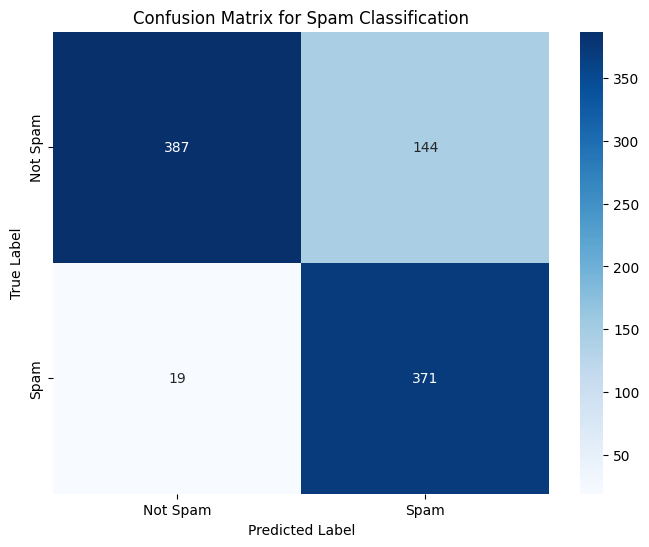

In [32]:
print("--- Confusion Matrix ---")
# Generate the matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

# Create a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Spam', 'Spam'], 
            yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Spam Classification')
plt.show()